## Simple Introduction to DFlat and It's Workflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import gc
from dflat.initialize import focusing_lens, Gaussian_lens
from dflat.metasurface import reverse_lookup_optimize, load_optical_model, export_geometry_to_comsol
from dflat.metasurface import build_transfer_targets, incident_field_to_amp_phase, load_field_table
from dflat.plot_utilities import mp_format
from dflat.propagation.propagators_legacy import PointSpreadFunction  # Using the legacy version as it takes wavelength as a forward input instead of initialization input

d:\PhD\Git\DFlat\.venv\Lib\site-packages\dflat\metasurface\load_utils.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


(1, 257, 257) (1, 257, 257) (1, 257, 257)


Text(0.5, 1.0, 'phase')

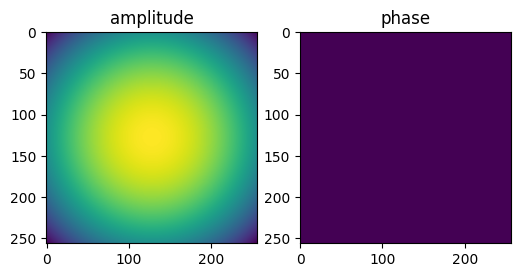

In [2]:
amp, phase, aperture = Gaussian_lens(
    in_size=[257,257],
    in_dx_m=[300e-9, 300e-9],
    wavelength_set_m=[600e-9],
    depth_set_m=[1e-3],
    waist_set_m=[1e-3]
)
# returns focusing profiles of shape [Z, Lam, H, W]
print(amp.shape, phase.shape, aperture.shape)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(amp[0]*aperture[0])
ax[0].set_title("amplitude")
ax[1].imshow(phase[0])
ax[1].set_title("phase")

Running optimization with device cuda
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600\model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Loss: 0.0641: 100%|██████████| 500/500 [00:11<00:00, 44.09it/s]       


Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600\model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


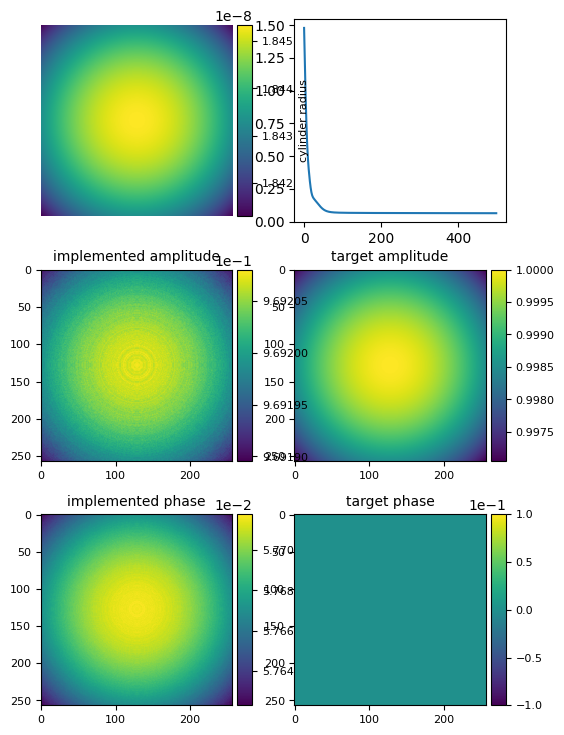

In [3]:
# Reverse look-up to find the metasurface that implements the target profile
model_name = "Nanocylinders_TiO2_U300H600"

p_norm, p, err = reverse_lookup_optimize(
    amp[None,None],
    phase[None,None],
    [600e-9],
    model_name,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,
    opt_phase_only=False)

# As a check, lets call the optical model and see what this metasurface does vs what we desired
model = load_optical_model(model_name)
model = model.to("cuda")

est_amp, est_phase = model(p, np.array([600e-9]), pre_normalized=False)
est_amp = est_amp.detach().cpu().numpy()
est_phase = est_phase.detach().cpu().numpy()

fig, ax = plt.subplots(3,2, figsize=(6,9))
ax[0,0].imshow(p.squeeze())
mp_format.format_plot(fig, ax[0,0], addcolorbar=True, setAspect="equal", cbartitle="cylinder radius")
ax[0,0].axis('off')
ax[0,1].plot(err)
ax[1,0].imshow(est_amp.squeeze())
mp_format.format_plot(fig, ax[1,0], title="implemented amplitude", addcolorbar=True, setAspect="equal")
ax[1,1].imshow(amp.squeeze())
mp_format.format_plot(fig, ax[1,1], title="target amplitude",  addcolorbar=True, setAspect="equal")
ax[2,0].imshow(est_phase.squeeze())
mp_format.format_plot(fig, ax[2,0], title="implemented phase", addcolorbar=True, setAspect="equal")
ax[2,1].imshow(phase.squeeze())
mp_format.format_plot(fig, ax[2,1], title="target phase", addcolorbar=True, setAspect="equal")

In [4]:
np.save("./data/designed_metasurface.npy", p)

In [5]:
est_phase = est_phase % (2*np.pi)
print(np.std(est_phase))

1.9813835e-05


$$\eta=\frac{\left|\iint_{\mathcal{A}}E_{\mathrm{imp}}(x,y)E_{\mathrm{tgt}}^*(x,y)dxdy\right|^2}{\left(\iint_{\mathcal{A}}|E_{\mathrm{imp}}|^2dxdy\right)\left(\iint_{\mathcal{A}}|E_{\mathrm{tgt}}|^2dxdy\right)}$$

In [6]:
# complex fields
E_tgt = amp.squeeze() * np.exp(1j * phase.squeeze())
E_imp = est_amp.squeeze() * np.exp(1j * est_phase.squeeze())

num = np.sum(E_imp * np.conj(E_tgt))
den = np.sqrt(np.sum(np.abs(E_imp)**2) * np.sum(np.abs(E_tgt)**2))
eta = np.abs(num / den)**2   # scalar in [0, 1]
print(f"Mode-overlap efficiency: {eta*100:.10f}%")

Mode-overlap efficiency: 99.9999610319%


In [18]:
df = load_field_table("test_field_data.txt")  # Load pre-saved field table for propagation test
print(df)

Ex = df["ExRe [V/m]"] + 1j*df["ExIm [V/m]"]
Ey = df["EyRe [V/m]"] + 1j*df["EyIm [V/m]"]
Ez = df["EzRe [V/m]"] + 1j*df["EzIm [V/m]"]

# Reshape to 2D arrays based on x and y coordinates
x_unique = df["x [um]"].unique()
y_unique = df["y [um]"].unique()
ny = len(y_unique)
nx = len(x_unique)

Ex = Ex.values.reshape(ny, nx)
Ey = Ey.values.reshape(ny, nx)
Ez = Ez.values.reshape(ny, nx)

print(f"Field shapes: Ex={Ex.shape}, Ey={Ey.shape}, Ez={Ez.shape}")
print(f"Grid dimensions: {nx} x positions, {ny} y positions")


      x [um]  y [um]     z [um]  ExRe [V/m]  ExIm [V/m]  EyRe [V/m]  \
0       -135    -200  181.02698   13892.904 -10456.2630  489.096310   
1       -125    -200  181.02698   14661.605 -10022.3030  266.428830   
2       -115    -200  181.02698   15917.681  -9225.8135   75.410492   
3       -105    -200  181.02698   17339.869  -8294.7529 -101.793370   
4        -95    -200  181.02698   18578.895  -7291.3267 -233.528590   
...      ...     ...        ...         ...         ...         ...   
1143      95     200  181.02698   18578.895  -7291.3267 -233.528590   
1144     105     200  181.02698   17339.869  -8294.7529 -101.793370   
1145     115     200  181.02698   15917.681  -9225.8135   75.410492   
1146     125     200  181.02698   14661.605 -10022.3030  266.428830   
1147     135     200  181.02698   13892.904 -10456.2630  489.096310   

      EyIm [V/m]  EzRe [V/m]  EzIm [V/m]  
0      2034.5439   7846.2681  -9441.8252  
1      1972.3324   8302.2197  -8250.3896  
2      1873.2574  

In [37]:
amp_in, phase_in = incident_field_to_amp_phase(Ex_prop, Ey_prop, Ez_prop, pol_vector=(1,1,1))
print(f"Input field amplitude range: {amp_in.min()} to {amp_in.max()}")

# Build transfer targets
amp_tgt, phase_tgt, aperture = Gaussian_lens(
    in_size=[257,257],
    in_dx_m=[600e-9, 600e-9],
    wavelength_set_m=[3e-5],
    depth_set_m=[1e-3],
    waist_set_m=[1e-3]
)

amp_target, phase_target, mask = build_transfer_targets(
    amp_tgt,
    phase_tgt,
    amp_in,
    phase_in
)
print(f"Transfer target shapes: {amp_target.detach().cpu().numpy().shape}, {phase_target.detach().cpu().numpy().shape}")

Input field amplitude range: 15877.716796875 to 49112.41796875
Transfer target shapes: (1, 257, 257), (1, 257, 257)


Running optimization with device cuda
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_Si3N4_U350H600\model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Loss: 0.2835: 100%|██████████| 500/500 [00:08<00:00, 56.61it/s]


Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_Si3N4_U350H600\model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


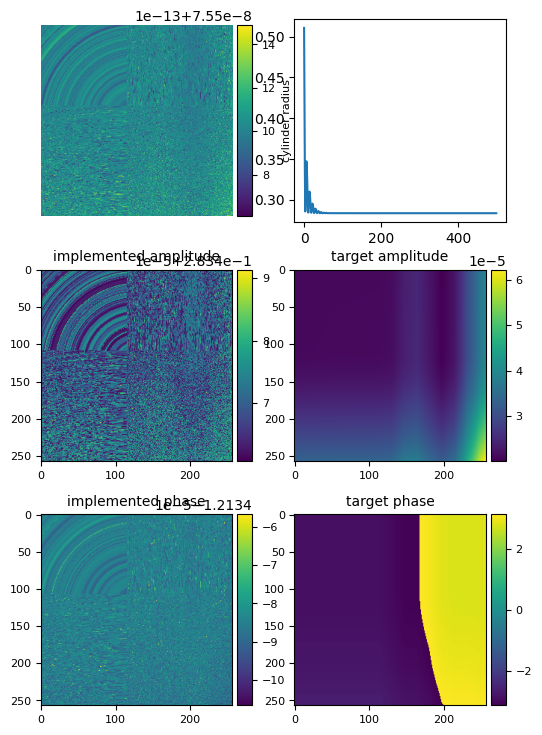

In [38]:
# Reverse look-up to find the metasurface that implements the target profile
model_name = "Nanocylinders_Si3N4_U350H600"

amp_target = amp_target.detach().cpu().numpy()
phase_target = phase_target.detach().cpu().numpy()

p_norm, p, err = reverse_lookup_optimize(
    amp_target[None,None],
    phase_target[None,None],
    [3e-5],
    model_name,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,
    opt_phase_only=False)

# As a check, lets call the optical model and see what this metasurface does vs what we desired
model = load_optical_model(model_name)
model = model.to("cuda")

est_amp, est_phase = model(p, np.array([3e-5]), pre_normalized=False)
est_amp = est_amp.detach().cpu().numpy()
est_phase = est_phase.detach().cpu().numpy()

fig, ax = plt.subplots(3,2, figsize=(6,9))
ax[0,0].imshow(p.squeeze())
mp_format.format_plot(fig, ax[0,0], addcolorbar=True, setAspect="equal", cbartitle="cylinder radius")
ax[0,0].axis('off')
ax[0,1].plot(err)
ax[1,0].imshow(est_amp.squeeze())
mp_format.format_plot(fig, ax[1,0], title="implemented amplitude", addcolorbar=True, setAspect="equal")
ax[1,1].imshow(amp_target.squeeze())
mp_format.format_plot(fig, ax[1,1], title="target amplitude",  addcolorbar=True, setAspect="equal")
ax[2,0].imshow(est_phase.squeeze())
mp_format.format_plot(fig, ax[2,0], title="implemented phase", addcolorbar=True, setAspect="equal")
ax[2,1].imshow(phase_target.squeeze())
mp_format.format_plot(fig, ax[2,1], title="target phase", addcolorbar=True, setAspect="equal")

(1, 257, 257) (1, 257, 257) (1, 257, 257)


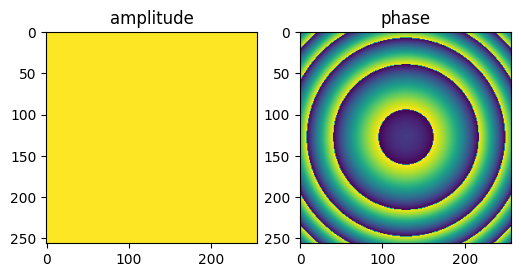

In [ ]:
amp, phase, aperture = focusing_lens(
    in_size=[257,257],
    in_dx_m=[300e-9, 300e-9],
    wavelength_set_m=[600e-9],
    depth_set_m=[1e-3],
    fshift_set_m=[[0.0, 0.0]],
    out_distance_m=1e-3,
    aperture_radius_m=None,
    radial_symmetry=False
)
# returns focusing profiles of shape [Z, Lam, H, W]
print(amp.shape, phase.shape, aperture.shape)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(amp[0]*aperture[0], vmin=0, vmax=1)
ax[0].set_title("amplitude")
ax[1].imshow(phase[0])
ax[1].set_title("phase")

Running optimization with device cuda
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Loss: 0.1864: 100%|██████████| 500/500 [00:06<00:00, 76.78it/s]       


Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


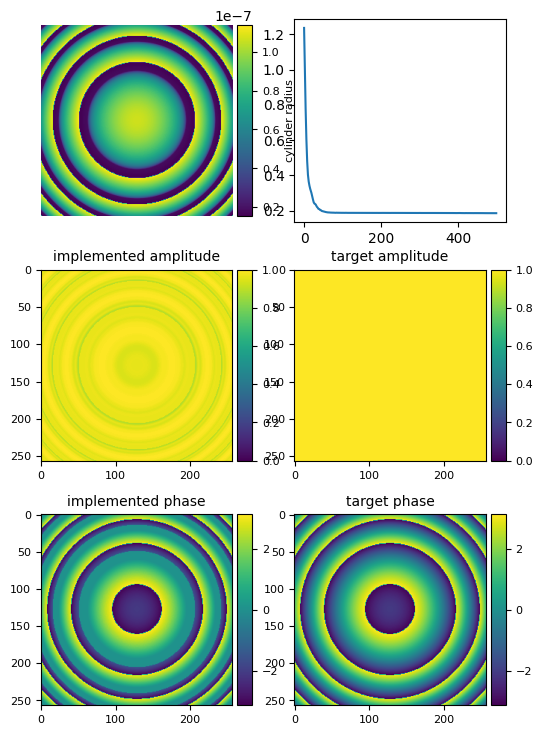

In [3]:
# Reverse look-up to find the metasurface that implements the target profile
model_name = "Nanocylinders_TiO2_U300H600"

p_norm, p, err = reverse_lookup_optimize(
    amp[None,None],
    phase[None,None],
    [600e-9],
    model_name,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,
    opt_phase_only=False)

# As a check, lets call the optical model and see what this metasurface does vs what we desired
model = load_optical_model(model_name)
model = model.to("cuda")

est_amp, est_phase = model(p, np.array([600e-9]), pre_normalized=False)
est_amp = est_amp.detach().cpu().numpy()
est_phase = est_phase.detach().cpu().numpy()

fig, ax = plt.subplots(3,2, figsize=(6,9))
ax[0,0].imshow(p.squeeze())
mp_format.format_plot(fig, ax[0,0], addcolorbar=True, setAspect="equal", cbartitle="cylinder radius")
ax[0,0].axis('off')
ax[0,1].plot(err)
ax[1,0].imshow(est_amp.squeeze(), vmin=0, vmax=1)
mp_format.format_plot(fig, ax[1,0], title="implemented amplitude", addcolorbar=True, setAspect="equal")
ax[1,1].imshow(amp.squeeze(), vmin=0, vmax=1)
mp_format.format_plot(fig, ax[1,1], title="target amplitude",  addcolorbar=True, setAspect="equal")
ax[2,0].imshow(est_phase.squeeze())
mp_format.format_plot(fig, ax[2,0], title="implemented phase", addcolorbar=True, setAspect="equal")
ax[2,1].imshow(phase.squeeze())
mp_format.format_plot(fig, ax[2,1], title="target phase", addcolorbar=True, setAspect="equal")

In [4]:
# Compute the point-spread function for this lens for different conditions
PSF = PointSpreadFunction(
    in_size=[257, 257],
    in_dx_m=[300e-9, 300e-9],
    out_distance_m=1e-3,
    out_size=[512, 512],
    out_dx_m=[500e-9, 500e-9],
    out_resample_dx_m=None,
    radial_symmetry=False,
    diffraction_engine="ASM")

ps_locs = [[0.0, 0.0, 5e-4], [0.0, 0.0, 1e-3], [0.0, 0.0, 5e-3]]
sim_wl = [500e-9, 600e-9, 700e-9]

intensity, phase = PSF(
    torch.tensor(est_amp, dtype=torch.float32, device='cuda'),
    torch.tensor(est_phase, dtype=torch.float32, device='cuda'),
    sim_wl,
    ps_locs,
    aperture=None,
    normalize_to_aperture=True)
intensity = intensity.cpu().numpy()
phase = phase.cpu().numpy()

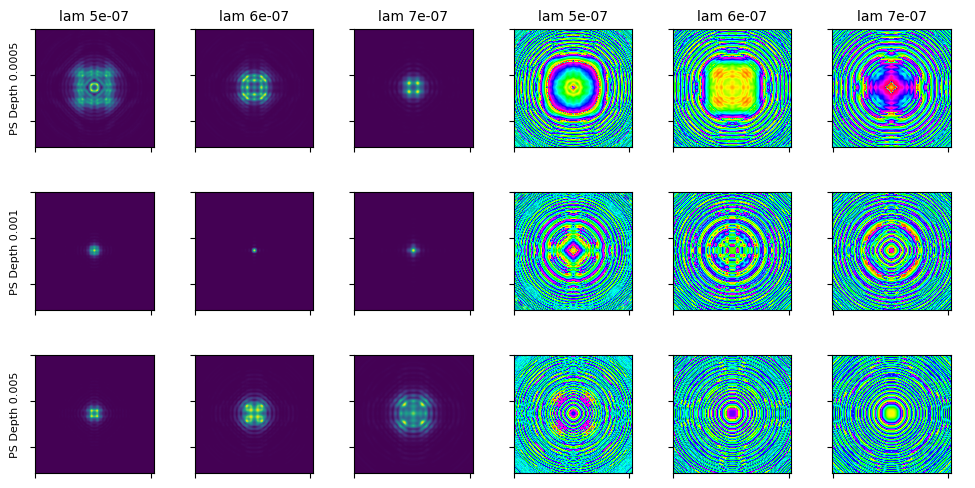

In [5]:
fig, ax = plt.subplots(3, 6, figsize=(12,6))
for z in range(3):
    for l in range(3):
        ax[z,l].imshow(intensity[0,0, z, l,:,:])
        mp_format.format_plot(
            fig, 
            ax[z,l],
            title= f"lam {sim_wl[l]}" if z==0 else "",
            rmvxLabel=True,
            rmvyLabel=True, 
            setAspect="equal")
        
    for l in np.arange(3,6,1):
        ax[z,l].imshow(phase[0,0, z, l-3,:,:], cmap='hsv')
        mp_format.format_plot(
            fig, 
            ax[z,l],
            title= f"lam {sim_wl[l-3]}" if z==0 else "",
            rmvxLabel=True,
            rmvyLabel=True, 
            setAspect="equal")
    ax[z,0].set_ylabel(f"PS Depth {ps_locs[z][2]}")

In [ ]:
# Write this lens to a gds file for fabrication
pfab = p.squeeze(0)
mask = np.ones(pfab.shape[0:2])
cell_size = [300e-9, 300e-9]
block_size =[300e-9, 300e-9] # This can be used to repeat the cell as a larger block

from dflat.GDSII.assemble import assemble_cylinder_gds
assemble_cylinder_gds(pfab, mask, cell_size, block_size, savepath="./file.gds")

Writing metasurface shapes to GDS File


  0%|          | 0/257 [00:00<?, ?it/s]

100%|██████████| 257/257 [00:02<00:00, 128.09it/s]


Completed writing and saving metasurface GDS File: Time:  2.311383008956909


In [7]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [8]:
import matplotlib.pyplot as plt
import mat73
from scipy import interpolate
import numpy as np
import torch
from einops import rearrange

from dflat.initialize import focusing_lens
from dflat.metasurface import reverse_lookup_optimize, load_optical_model
from dflat.propagation.propagators_legacy import PointSpreadFunction # Using the legacy version as it takes wavelength as a forward input instead of initialization input
from dflat.render import hsi_to_rgb
from dflat.plot_utilities import format_plot
from dflat.render import Fronto_Planar_Renderer_Incoherent

In [9]:
settings = {
    "in_size": [513, 513],
    "in_dx_m": [10*300e-9, 10*300e-9],
    "wavelength_set_m": [550e-9],
    "depth_set_m": [1e-2],
    "fshift_set_m": [[0.0, 0.0]],
    "out_distance_m": 1e-2,
    "aperture_radius_m": None,
    "radial_symmetry": True
    }
amp, phase, aperture = focusing_lens(**settings)
print(amp.shape, phase.shape, aperture.shape)
#  Phase, and Aperture profiles of shape [Z, Lam, H, W]

# Reverse look-up to find the metasurface that implements the target profile
model_name = "Nanocylinders_TiO2_U300H600"
p_norm, p, err = reverse_lookup_optimize(
    amp[None, None],
    phase[None, None],
    [550e-9],
    model_name,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,
    opt_phase_only=False)
print(p.shape)
# [B, H, W, D] where D is the number of shape parameters. 

# Predict the broadband phase and amplitude imparted by this collection of meta-atoms
model = load_optical_model(model_name)
model = model.to("cuda")
sim_wl = np.linspace(400e-9, 700e-9, 31)
est_amp, est_phase = model(p, sim_wl, pre_normalized=False)
print(est_amp.shape, est_phase.shape) 
# [B, pol, Lam, H, W] where pol is 1 or 2

# Compute the point spread function given this broadband stack of field amplitude and phases
PSF = PointSpreadFunction(
    in_size=[513, 513],
    in_dx_m=[10*300e-9, 10*300e-9],
    out_distance_m=1e-2,
    out_size=[512, 512],
    out_dx_m=[5e-6,5e-6],
    out_resample_dx_m=None,
    radial_symmetry=True,
    diffraction_engine="ASM")
ps_locs = [[0.0, 0.0, 1e-2]]

psf_intensity, _ = PSF(
    est_amp.to(dtype=torch.float32, device='cuda'),
    est_phase.to(dtype=torch.float32, device='cuda'),
    sim_wl,
    ps_locs,
    aperture=None,
    normalize_to_aperture=True)
print(psf_intensity.shape)
# shape [B P Z L H W]

(1, 1, 257) (1, 1, 257) (1, 1, 257)
Running optimization with device cuda
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Loss: 0.1220: 100%|██████████| 500/500 [00:02<00:00, 241.85it/s]


(1, 1, 257, 1)
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys
torch.Size([1, 1, 31, 1, 257]) torch.Size([1, 1, 31, 1, 257])
torch.Size([1, 1, 1, 31, 512, 512])
